***Import Libraries***

In [40]:
import os
import zipfile
import random
import shutil

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from prettytable import PrettyTable


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array
from keras.models import Sequential, Model
from tensorflow.keras import Sequential, layers, Model
from keras.layers import Input, Dense, Flatten, Convolution2D, MaxPooling2D, Conv2D, Reshape, Conv2DTranspose, GlobalAveragePooling2D
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications import ResNet50

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Preparing Data***

In [7]:
#Function to print tests information

def print_info( test_gen, preds, print_code ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             
    classes=list(new_dict.values())   
    dict_as_text=str(new_dict)
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i] 
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print(msg)
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print(msg,)            
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print(msg)
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) 
                plot_class.append(value) 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [8]:
#Extract files to tmp
zip_path = zipfile.ZipFile('/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset.zip', 'r')
zip_path.extractall('/tmp')
zip_path.close()

In [9]:
class_list = os.listdir('/tmp/Grapevine_Leaves_Image_Dataset/')
class_directory = {"Ak": 0, "Ala_Idris": 1, "Buzgulu": 2, "Dimnit": 3, "Nazli": 4}

train_data = []

train_labels = []

for class_folder in class_list:
    if class_folder[0] != 'G':
        file_names = os.listdir(os.path.join("/tmp/Grapevine_Leaves_Image_Dataset/", class_folder))
        for file_name in file_names:
            image = mpimg.imread(os.path.join("/tmp/Grapevine_Leaves_Image_Dataset/", class_folder, file_name))
            resized = cv.resize(image, (320,320), interpolation=cv.INTER_AREA)
            train_data.append(resized)
            train_labels.append(class_directory[class_folder])

train_data = np.array(train_data)
train_labels = np.array(train_labels)

In [11]:
train_labels = train_labels.reshape((-1, 1))
train_data.shape, train_labels.shape

((500, 320, 320, 4), (500, 1))

In [18]:
df = pd.DataFrame()
df['image'] = os.listdir('/tmp/Grapevine_Leaves_Image_Dataset/Ak') + os.listdir('/tmp/Grapevine_Leaves_Image_Dataset/Ala_Idris') + os.listdir('/tmp/Grapevine_Leaves_Image_Dataset/Buzgulu') + os.listdir('/tmp/Grapevine_Leaves_Image_Dataset/Dimnit') + os.listdir('/tmp/Grapevine_Leaves_Image_Dataset/Nazli')
classes = []
paths = []
for image in df['image']:
    var = image.split(' (')[0]
    classes.append(var)
    paths.append('/tmp/Grapevine_Leaves_Image_Dataset/' + var + '/' + image)
df['class'] = classes
df['path'] = paths
df.head()

,image,class,path
0,Ak (6).png,Ak,/tmp/Grapevine_Leaves_Image_Dataset/Ak/Ak (6).png
1,Ak (30).png,Ak,/tmp/Grapevine_Leaves_Image_Dataset/Ak/Ak (30)...
2,Ak (35).png,Ak,/tmp/Grapevine_Leaves_Image_Dataset/Ak/Ak (35)...
3,Ak (72).png,Ak,/tmp/Grapevine_Leaves_Image_Dataset/Ak/Ak (72)...
4,Ak (62).png,Ak,/tmp/Grapevine_Leaves_Image_Dataset/Ak/Ak (62)...


In [20]:
#Check if data is complete

print('Leaves varitey Count: ',len(df['class'].value_counts()))
df['class'].value_counts()

Leaves varitey Count:  5


Ak           100
Ala_Idris    100
Buzgulu      100
Dimnit       100
Nazli        100
Name: class, dtype: int64

In [19]:
#Split train and test data(80:20)
trainDf, testDf = train_test_split(df, random_state = 95, test_size = 0.2)
len(trainDf)

400

# ***Data Augmentation***

In [23]:
datagen = ImageDataGenerator(
    brightness_range=[0.1,1.8],
    vertical_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)

testgen = ImageDataGenerator()

trainGenerator = datagen.flow_from_dataframe(
    trainDf,
    x_col= 'path',
    y_col='class',
    target_size = (360, 360),
    batch_size = 32,
    shuffle = False,
    class_mode='categorical',
    subset = 'training'
)

valGenerator = datagen.flow_from_dataframe(
    trainDf,
    x_col= 'path',
    y_col='class',
    target_size = (360, 360),
    batch_size = 32,
    shuffle = False,
    class_mode='categorical',
    subset = 'validation'
)

testGenerator = testgen.flow_from_dataframe(
    testDf,
    x_col= 'path',
    y_col='class',
    target_size = (360, 360),
    batch_size = 32,
    shuffle = False,
    class_mode='categorical'
)

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.


# ***ResNet50***

In [24]:
resnet50 = ResNet50(include_top = False, input_shape = (360,360,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(5, activation='softmax')(x)

model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [25]:
history_resnet50 = model_resnet50.fit(
      trainGenerator,
      validation_data = valGenerator,
      epochs=50)

Epoch 1/50
10/10 [==============================] - 21s 2s/step - loss: 1.6399 - accuracy: 0.2688 - val_loss: 1.5137 - val_accuracy: 0.3125
Epoch 2/50
10/10 [==============================] - 14s 1s/step - loss: 1.4541 - accuracy: 0.3906 - val_loss: 1.3708 - val_accuracy: 0.4625
Epoch 3/50
10/10 [==============================] - 14s 1s/step - loss: 1.3034 - accuracy: 0.4469 - val_loss: 1.3652 - val_accuracy: 0.3875
Epoch 4/50
10/10 [==============================] - 14s 1s/step - loss: 1.2562 - accuracy: 0.4875 - val_loss: 1.1239 - val_accuracy: 0.6750
Epoch 5/50
10/10 [==============================] - 14s 1s/step - loss: 1.1036 - accuracy: 0.6750 - val_loss: 1.0713 - val_accuracy: 0.6500
Epoch 6/50
10/10 [==============================] - 14s 1s/step - loss: 1.0495 - accuracy: 0.6500 - val_loss: 0.9948 - val_accuracy: 0.6750
Epoch 7/50
10/10 [==============================] - 14s 1s/step - loss: 1.0115 - accuracy: 0.6562 - val_loss: 0.9198 - val_accuracy: 0.8125
Epoch 8/50
10/10 [==

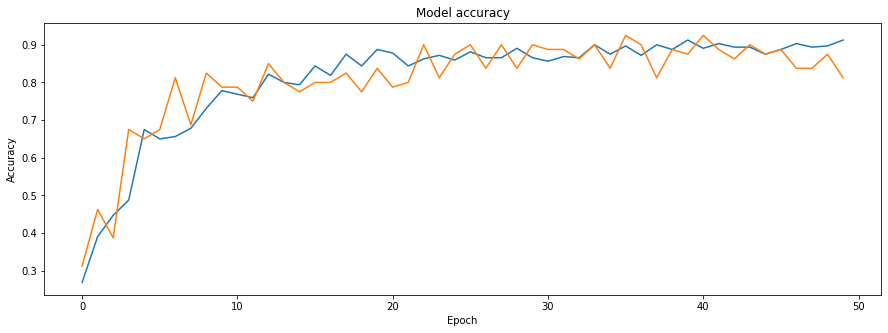

In [26]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

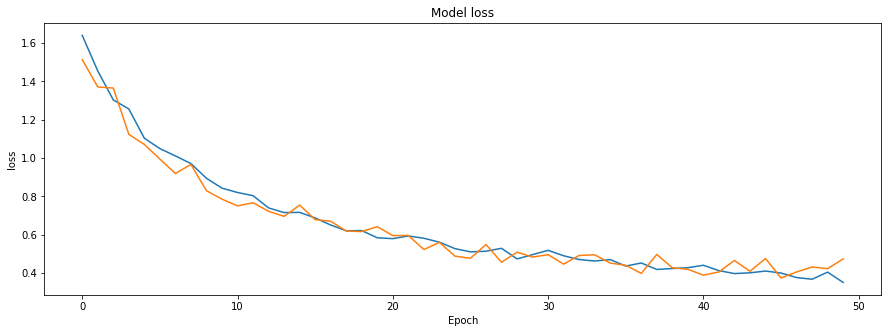

In [27]:
plt.figure(figsize=(15,5))
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [28]:
training_accuracy_resnet      = history_resnet50.history['accuracy'][-1]
training_loss_resnet          = history_resnet50.history['loss'][-1]
validation_accuracy_resnet    = history_resnet50.history['val_accuracy'][-1]
validation_loss_resnet        = history_resnet50.history['val_loss'][-1]
print("Training Accuracy ResNet   :", training_accuracy_resnet )
print("Training Loss ResNet       :", training_loss_resnet)
print("Validation Accuracy ResNet :", validation_accuracy_resnet)
print("Validation Loss ResNet     :", validation_loss_resnet)

Training Accuracy ResNet   : 0.9125000238418579
Training Loss ResNet       : 0.3518506586551666
Validation Accuracy ResNet : 0.8125
Validation Loss ResNet     : 0.47468405961990356


In [29]:
acc = model_resnet50.evaluate(testGenerator, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)

4/4 [==============================] - 2s 462ms/step - loss: 0.4140 - accuracy: 0.8500
accuracy on the test set is 85.00 %


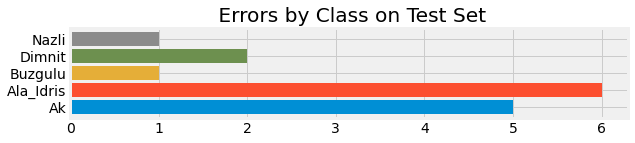

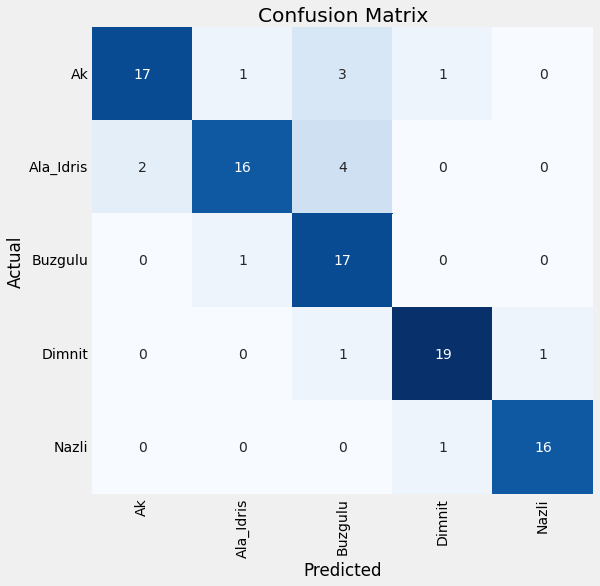

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.89      0.77      0.83        22
   Ala_Idris       0.89      0.73      0.80        22
     Buzgulu       0.68      0.94      0.79        18
      Dimnit       0.90      0.90      0.90        21
       Nazli       0.94      0.94      0.94        17

    accuracy                           0.85       100
   macro avg       0.86      0.86      0.85       100
weighted avg       0.86      0.85      0.85       100



In [30]:
preds = model_resnet50.predict(testGenerator)
print_info( testGenerator, preds, 0)

***Random Seed***

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 23s 2s/step - loss: 1.6453 - accuracy: 0.2719 - val_loss: 1.4490 - val_accuracy: 0.4375
Epoch 2/15
10/10 [==============================] - 18s 2s/step - loss: 1.4281 - accuracy: 0.4219 - val_loss: 1.3270 - val_accuracy: 0.5000
Epoch 3/15
10/10 [==============================] - 19s 2s/step - loss: 1.2593 - accuracy: 0.5750 - val_loss: 1.2301 - val_accuracy: 0.5875
Epoch 4/15
10/10 [==============================] - 20s 2s/step - loss: 1.1716 - accuracy: 0.6094 - val_loss: 1.1419 - val_accuracy: 0.6375
Epoch 5/15
10/10 [==============================] - 14s 1s/step - loss: 1.0998 - accuracy: 0.6625 - val_loss: 1.0960 - val_accuracy: 0.6125
Epoch 6/15
10/10 [==============================] - 16s 2s/step - loss: 1.0082 - accuracy: 0.6844 - val_loss: 0.8958 - va

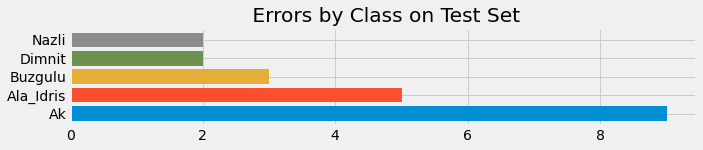

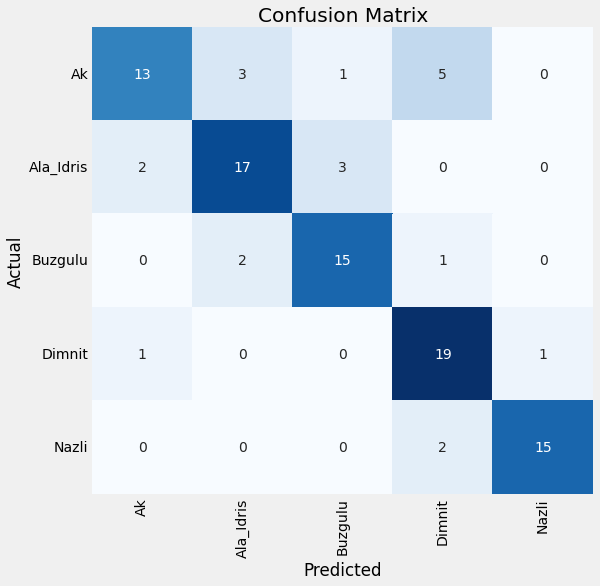

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.81      0.59      0.68        22
   Ala_Idris       0.77      0.77      0.77        22
     Buzgulu       0.79      0.83      0.81        18
      Dimnit       0.70      0.90      0.79        21
       Nazli       0.94      0.88      0.91        17

    accuracy                           0.79       100
   macro avg       0.80      0.80      0.79       100
weighted avg       0.80      0.79      0.79       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 1.6622 - accuracy: 0.2438 - val_loss: 1.4199 - val_accuracy: 0.4000
Epoch 2/15
10/10 [==============================] - 16s 2s/step - loss: 1.4860 - accuracy: 0.3375 - val_loss: 1.3206 - val_accuracy: 0.5125
Epoch

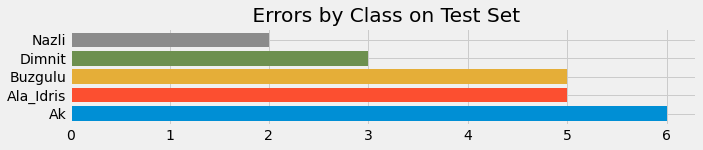

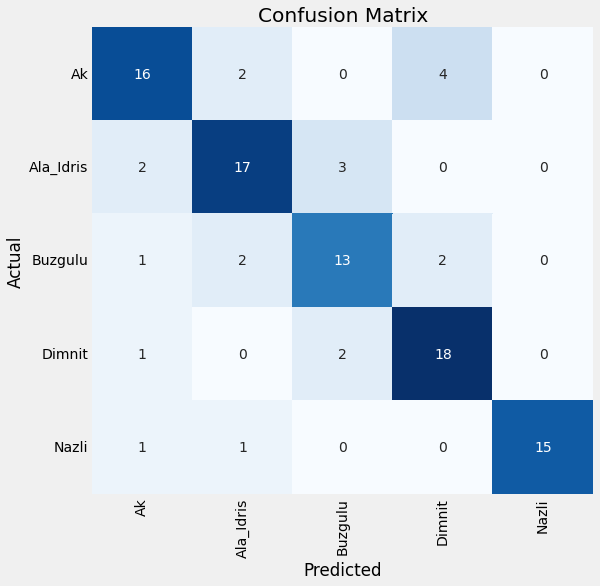

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.76      0.73      0.74        22
   Ala_Idris       0.77      0.77      0.77        22
     Buzgulu       0.72      0.72      0.72        18
      Dimnit       0.75      0.86      0.80        21
       Nazli       1.00      0.88      0.94        17

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.80       100
weighted avg       0.80      0.79      0.79       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 20s 2s/step - loss: 1.6118 - accuracy: 0.2906 - val_loss: 1.4730 - val_accuracy: 0.3125
Epoch 2/15
10/10 [==============================] - 15s 1s/step - loss: 1.4540 - accuracy: 0.3500 - val_loss: 1.3886 - val_accuracy: 0.4375
Epoch

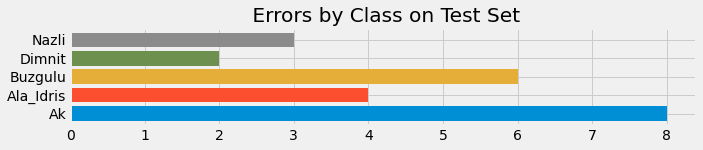

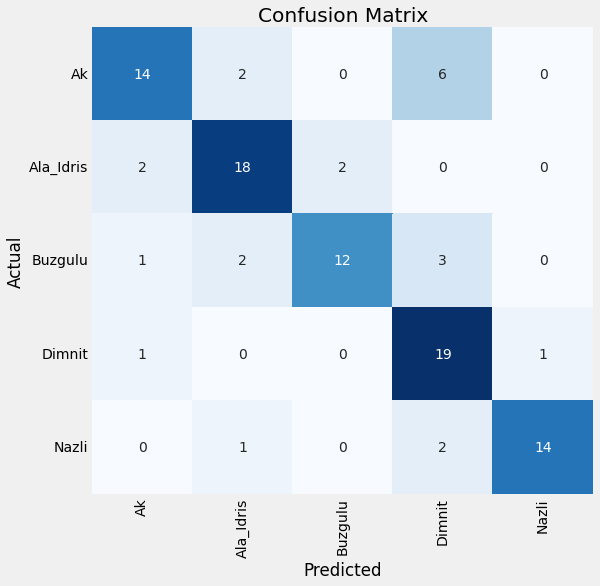

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.78      0.64      0.70        22
   Ala_Idris       0.78      0.82      0.80        22
     Buzgulu       0.86      0.67      0.75        18
      Dimnit       0.63      0.90      0.75        21
       Nazli       0.93      0.82      0.87        17

    accuracy                           0.77       100
   macro avg       0.80      0.77      0.77       100
weighted avg       0.79      0.77      0.77       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 1.5745 - accuracy: 0.2750 - val_loss: 1.5511 - val_accuracy: 0.3250
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 1.3963 - accuracy: 0.4625 - val_loss: 1.2998 - val_accuracy: 0.5125
Epoch

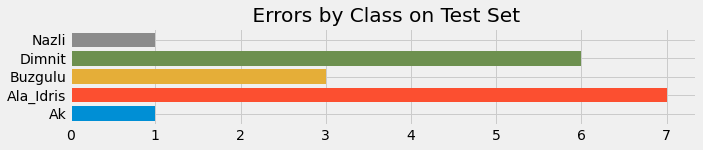

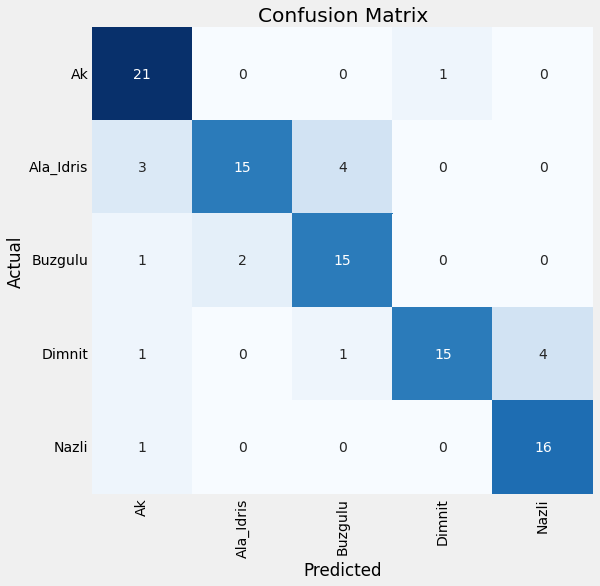

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.78      0.95      0.86        22
   Ala_Idris       0.88      0.68      0.77        22
     Buzgulu       0.75      0.83      0.79        18
      Dimnit       0.94      0.71      0.81        21
       Nazli       0.80      0.94      0.86        17

    accuracy                           0.82       100
   macro avg       0.83      0.83      0.82       100
weighted avg       0.83      0.82      0.82       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 1.6404 - accuracy: 0.2531 - val_loss: 1.5462 - val_accuracy: 0.2500
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 1.4548 - accuracy: 0.3906 - val_loss: 1.3920 - val_accuracy: 0.4375
Epoch

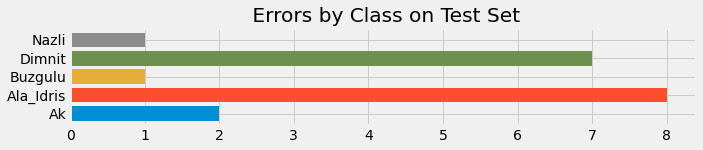

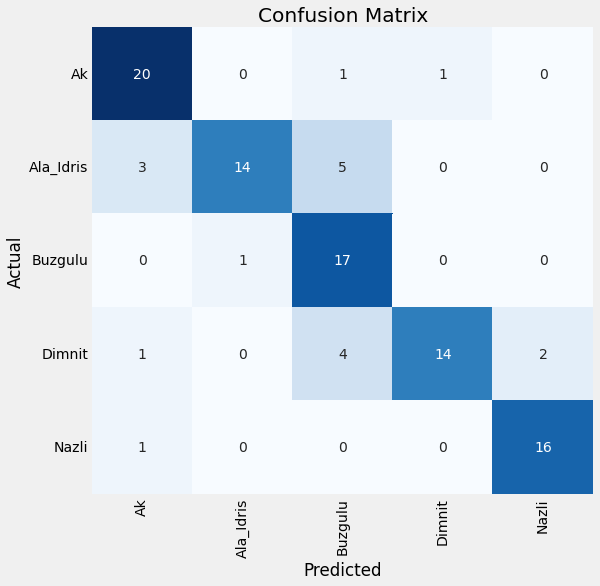

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.80      0.91      0.85        22
   Ala_Idris       0.93      0.64      0.76        22
     Buzgulu       0.63      0.94      0.76        18
      Dimnit       0.93      0.67      0.78        21
       Nazli       0.89      0.94      0.91        17

    accuracy                           0.81       100
   macro avg       0.84      0.82      0.81       100
weighted avg       0.84      0.81      0.81       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 21s 2s/step - loss: 1.6184 - accuracy: 0.2406 - val_loss: 1.5883 - val_accuracy: 0.2375
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 1.4588 - accuracy: 0.3812 - val_loss: 1.4080 - val_accuracy: 0.4125
Epoch

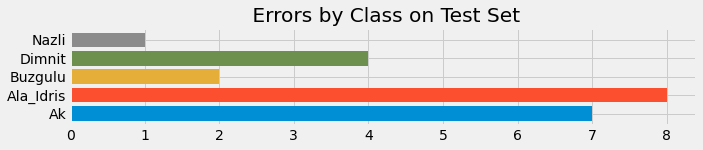

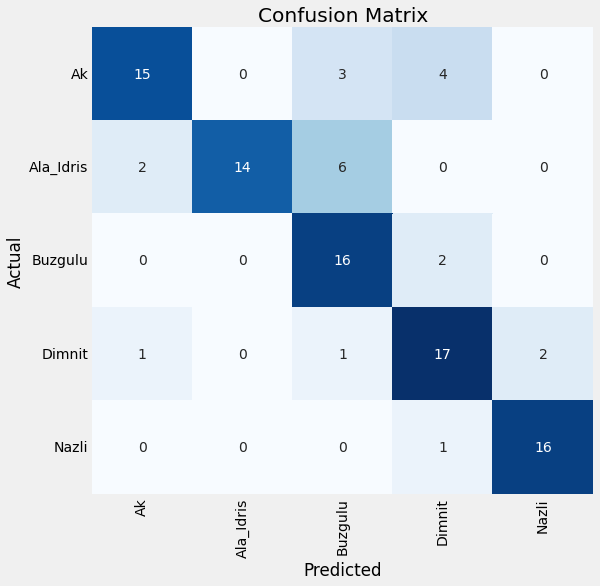

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.83      0.68      0.75        22
   Ala_Idris       1.00      0.64      0.78        22
     Buzgulu       0.62      0.89      0.73        18
      Dimnit       0.71      0.81      0.76        21
       Nazli       0.89      0.94      0.91        17

    accuracy                           0.78       100
   macro avg       0.81      0.79      0.78       100
weighted avg       0.81      0.78      0.78       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 21s 2s/step - loss: 1.6420 - accuracy: 0.2438 - val_loss: 1.5844 - val_accuracy: 0.2500
Epoch 2/15
10/10 [==============================] - 15s 1s/step - loss: 1.4356 - accuracy: 0.4219 - val_loss: 1.3803 - val_accuracy: 0.4750
Epoch

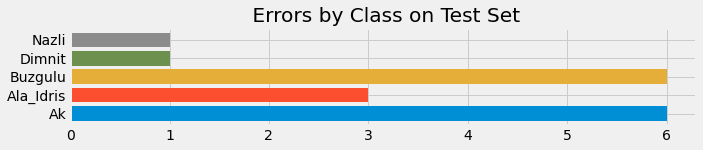

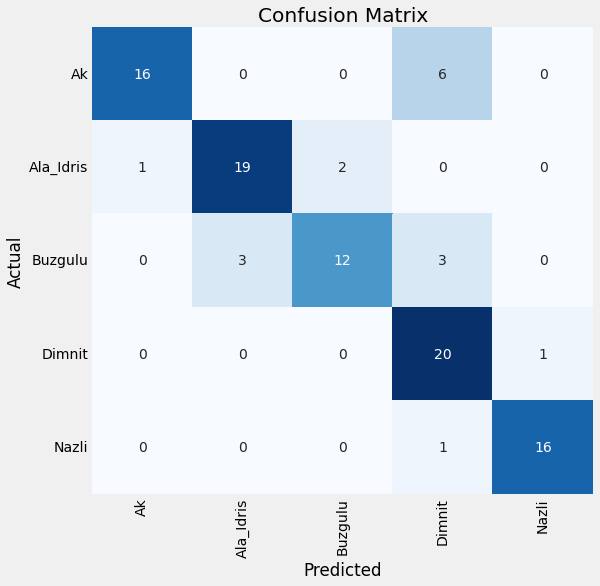

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.94      0.73      0.82        22
   Ala_Idris       0.86      0.86      0.86        22
     Buzgulu       0.86      0.67      0.75        18
      Dimnit       0.67      0.95      0.78        21
       Nazli       0.94      0.94      0.94        17

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 20s 2s/step - loss: 1.7343 - accuracy: 0.2406 - val_loss: 1.5584 - val_accuracy: 0.2500
Epoch 2/15
10/10 [==============================] - 16s 2s/step - loss: 1.4648 - accuracy: 0.3688 - val_loss: 1.3146 - val_accuracy: 0.5625
Epoch

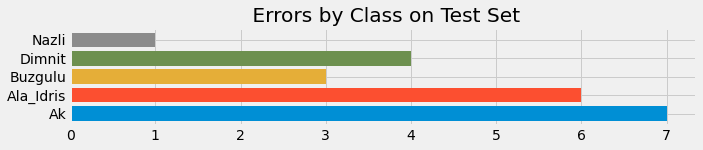

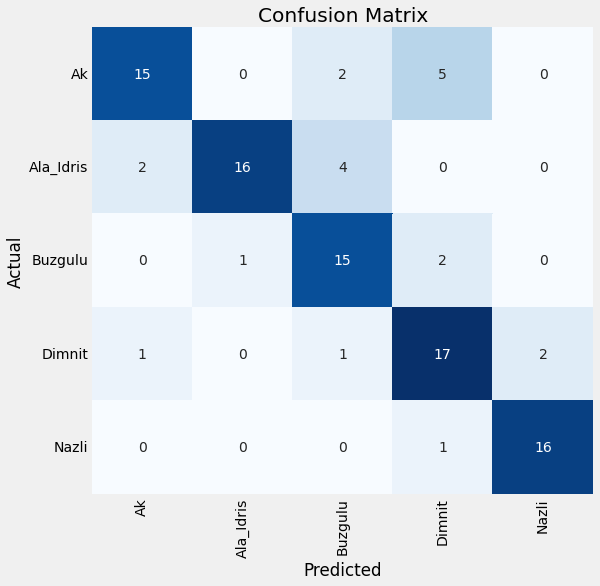

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.83      0.68      0.75        22
   Ala_Idris       0.94      0.73      0.82        22
     Buzgulu       0.68      0.83      0.75        18
      Dimnit       0.68      0.81      0.74        21
       Nazli       0.89      0.94      0.91        17

    accuracy                           0.79       100
   macro avg       0.81      0.80      0.79       100
weighted avg       0.81      0.79      0.79       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 1.6585 - accuracy: 0.2219 - val_loss: 1.4629 - val_accuracy: 0.4250
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 1.4545 - accuracy: 0.3750 - val_loss: 1.3604 - val_accuracy: 0.5125
Epoch

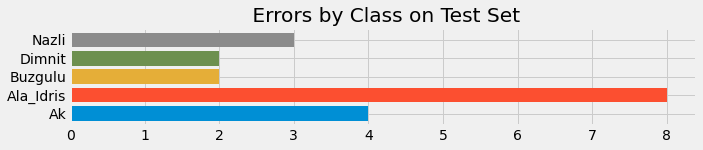

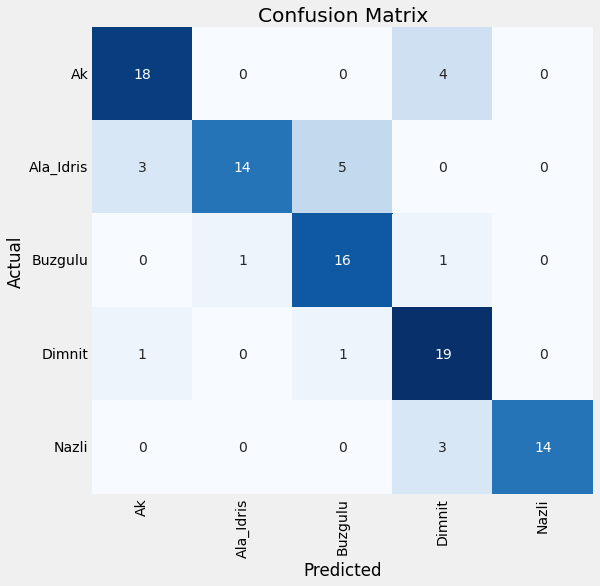

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.82      0.82      0.82        22
   Ala_Idris       0.93      0.64      0.76        22
     Buzgulu       0.73      0.89      0.80        18
      Dimnit       0.70      0.90      0.79        21
       Nazli       1.00      0.82      0.90        17

    accuracy                           0.81       100
   macro avg       0.84      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

Found 320 validated image filenames belonging to 5 classes.
Found 80 validated image filenames belonging to 5 classes.
Found 100 validated image filenames belonging to 5 classes.
Epoch 1/15
10/10 [==============================] - 19s 2s/step - loss: 1.5655 - accuracy: 0.2937 - val_loss: 1.4421 - val_accuracy: 0.3625
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 1.3933 - accuracy: 0.4344 - val_loss: 1.3027 - val_accuracy: 0.5500
Epoch

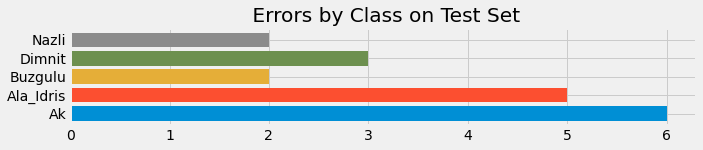

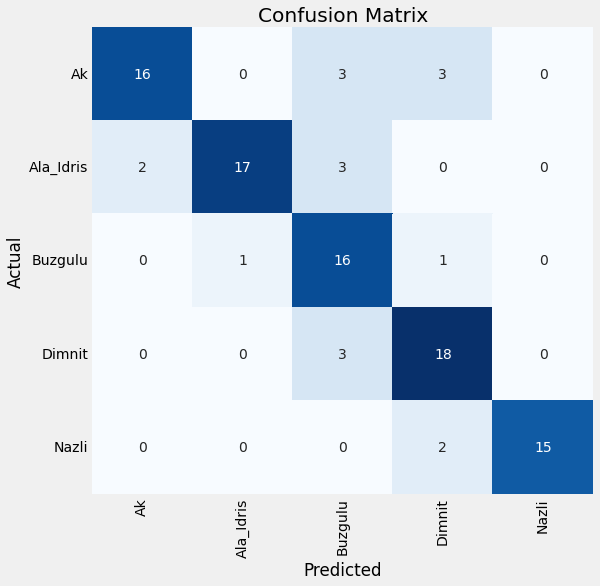

Classification Report:
----------------------
               precision    recall  f1-score   support

          Ak       0.89      0.73      0.80        22
   Ala_Idris       0.94      0.77      0.85        22
     Buzgulu       0.64      0.89      0.74        18
      Dimnit       0.75      0.86      0.80        21
       Nazli       1.00      0.88      0.94        17

    accuracy                           0.82       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.85      0.82      0.82       100



In [55]:
import random
mean_accuracy = 0

for i in range(10):
    seed = random.randint(0,100)

    train, test = train_test_split(df, random_state = seed, test_size = 0.2)
    
    datagen = ImageDataGenerator(
        brightness_range=[0.1,1.8],
        vertical_flip=True,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        validation_split = 0.2
    )

    testgen = ImageDataGenerator()

    trainGenerator = datagen.flow_from_dataframe(
        trainDf,
        x_col= 'path',
        y_col='class',
        target_size = (360, 360),
        batch_size = 32,
        shuffle = False,
        class_mode='categorical',
        subset = 'training'
    )

    valGenerator = datagen.flow_from_dataframe(
        trainDf,
        x_col= 'path',
        y_col='class',
        target_size = (360, 360),
        batch_size = 32,
        shuffle = False,
        class_mode='categorical',
        subset = 'validation'
    )

    testGenerator = testgen.flow_from_dataframe(
        testDf,
        x_col= 'path',
        y_col='class',
        target_size = (360, 360),
        batch_size = 32,
        shuffle = False,
        class_mode='categorical'
    )

    resnet50 = ResNet50(include_top = False, input_shape = (511,511,3), weights = 'imagenet')

    for layer in resnet50.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(resnet50.output)
    predictions = Dense(5, activation='softmax')(x)

    model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)
    model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    history_resnet50 = model_resnet50.fit(
      trainGenerator,
      validation_data = valGenerator,
      epochs = 15)
    
    valRes = model_resnet50.evaluate(valGenerator)
    testRes = model_resnet50.evaluate(testGenerator)
    print("Validation Result: ", valRes)
    print("Test Result: ", testRes)
    print("\n")
    preds = model_resnet50.predict(testGenerator)
    print_info(testGenerator, preds, 0)
    mean_accuracy += testRes[1]

In [57]:
print("Mean accuracy of ResNet Model with 10 random seeds: ", mean_accuracy/10)

Mean accuracy of ResNet Model with 10 random seeds:  0.8009999990463257


# ***DRA***

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, shuffle=True, random_state=101)

In [34]:
input = layers.Input(shape=(320, 320, 4))

# Encoder
x = Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Flatten()(x)
latent_space = Dense(1024)(x)
x = Dense(20*20*16)(latent_space)
x = Reshape(target_shape=(20, 20,16))(x)

# Decoder
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(4, (3, 3), activation="sigmoid", padding="same")(x)


In [35]:
# Autoencoder
autoencoder = Model(input, x)
encoder = Model(input, latent_space)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 320, 320, 4)]     0         
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 64)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 32)        9248

In [46]:
autoencoder.fit(
    x=X_train,
    y=X_train,
    epochs=50,
    batch_size=32,
    steps_per_epoch = 10,
    shuffle=False,
    validation_data=(X_test, X_test)
)

Epoch 1/50
10/10 [==============================] - 6s 592ms/step - loss: 0.1767 - val_loss: 0.2390
Epoch 2/50
10/10 [==============================] - 5s 479ms/step - loss: 0.1792 - val_loss: 0.2435
Epoch 3/50
10/10 [==============================] - 5s 484ms/step - loss: 0.1838 - val_loss: 0.2420
Epoch 4/50
10/10 [==============================] - 5s 486ms/step - loss: 0.2048 - val_loss: 0.2559
Epoch 5/50
10/10 [==============================] - 5s 515ms/step - loss: 0.2050 - val_loss: 0.2457
Epoch 6/50
10/10 [==============================] - 5s 489ms/step - loss: 0.1952 - val_loss: 0.2286
Epoch 7/50
10/10 [==============================] - 5s 483ms/step - loss: 0.1918 - val_loss: 0.2339
Epoch 8/50
10/10 [==============================] - 5s 481ms/step - loss: 0.1890 - val_loss: 0.2295
Epoch 9/50
10/10 [==============================] - 5s 503ms/step - loss: 0.1817 - val_loss: 0.2283
Epoch 10/50
10/10 [==============================] - 5s 502ms/step - loss: 0.1786 - val_loss: 0.2335

In [49]:
encoded_train = encoder.predict(X_train)
encoded_test = encoder.predict(X_test)

In [50]:
tn = []
for a in y_train:
    tn.append(a[0])
tn = np.array(tn)

In [51]:
rfc = RandomForestClassifier(n_jobs = -1, n_estimators = 28)
rfc = rfc.fit(encoded_train, tn)

In [52]:
rfc_pred = rfc.predict(encoded_test)

res = PrettyTable(["Accuracy of test data" ,"Cross Validation"])
rfc_acc_test = accuracy_score(rfc_pred, y_test)
rfc_scores = cross_val_score(rfc, encoded_train, y_train, cv=5)
res.add_row([rfc_acc_test, rfc_scores.mean()])
print(res)
res.clear()

cm = confusion_matrix(y_test, rfc_pred)
print(cm)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

+-----------------------+---------------------+
| Accuracy of test data |   Cross Validation  |
+-----------------------+---------------------+
|          0.29         | 0.32749999999999996 |
+-----------------------+---------------------+
[[ 8  2  4  0  1]
 [10  5  2  2  0]
 [ 6  9  9  2  0]
 [ 4  2  8  5  2]
 [ 7  8  0  2  2]]


# ***10 Fold Cross Validation***

In [15]:
kf = KFold(n_splits = 10)

In [22]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

fold_var = 1

datagen = ImageDataGenerator(
    brightness_range=[0.1,1.8],
    vertical_flip=True,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2
)


for train_index, val_index in kf.split(trainDf):
	training_data = trainDf.iloc[train_index]
	validation_data = trainDf.iloc[val_index]

	trainGenerator = datagen.flow_from_dataframe(
        training_data,
        x_col= 'path',
        y_col='class',
        target_size = (320, 320),
        batch_size = 32,
        shuffle = False,
        class_mode='categorical')
    
	valGenerator = datagen.flow_from_dataframe(
        validation_data,
        x_col= 'path',
        y_col='class',
        target_size = (320, 320),
        batch_size = 32,
        shuffle = False,
        class_mode='categorical')

	resnet50 = ResNet50(include_top = False, input_shape = (320,320,3), weights = 'imagenet')

    # training of all the convolution is set to false
	for layer in resnet50.layers:
		layer.trainable = False

	x = GlobalAveragePooling2D()(resnet50.output)
	predictions = Dense(5, activation='softmax')(x)

	model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

	model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
	
	
	history_resnet50 = model_resnet50.fit(
      trainGenerator,
      validation_data = valGenerator,
      epochs = 10)
	
	results = model_resnet50.evaluate(valGenerator)
	
	VALIDATION_ACCURACY.append(results[1]*100)
	VALIDATION_LOSS.append(results[0]*100)
	print('Accuracy = ', results[1]*100)
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Found 360 validated image filenames belonging to 5 classes.
Found 40 validated image filenames belonging to 5 classes.
94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
12/12 [==============================] - 28s 1s/step - loss: 1.7046 - accuracy: 0.2444 - val_loss: 1.5633 - val_accuracy: 0.3000
Epoch 2/10
12/12 [==============================] - 12s 975ms/step - loss: 1.4604 - accuracy: 0.3611 - val_loss: 1.1851 - val_accuracy: 0.6250
Epoch 3/10
12/12 [==============================] - 12s 976ms/step - loss: 1.3049 - accuracy: 0.5250 - val_loss: 1.1322 - val_accuracy: 0.6500
Epoch 4/10
12/12 [==============================] - 12s 990ms/step - loss: 1.1731 - accuracy: 0.5389 - val_loss: 1.0863 - val_accuracy: 0.6500
Epoch 5/10
12/12 [==============================] - 13s 1s/step - loss: 1.0584 - accuracy: 0.6111 - val_loss: 1.0407 - val_accuracy: 0.6750
Epoch 6/10
12/12 [==============================] - 13s 1s/step - loss: 0.9669 - accuracy: 0.6833 - val_los

In [56]:
sm = 0
for x in VALIDATION_ACCURACY:
  sm += x
print(sm/10)

70.24999976158142
